In [1]:
#import libraries
from skimage.filters import threshold_sauvola
import matplotlib.pyplot as plt
from skimage import data, io
from skimage.color import rgb2gray, label2rgb
from skimage.morphology import skeletonize, remove_small_objects
from skimage.filters import gaussian
#from skan.pre import threshold
import numpy as np
#import numba
import os

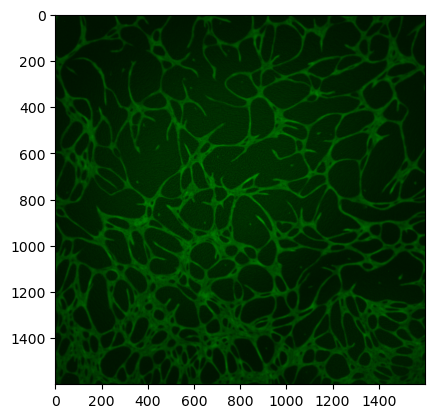

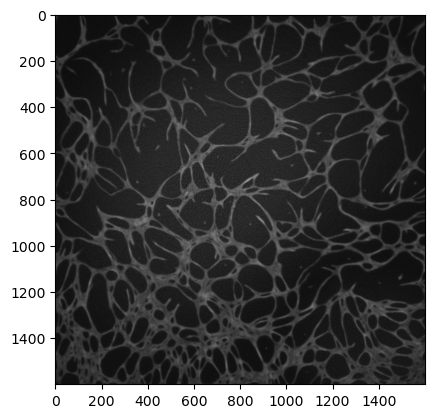

In [2]:
# os.chdir("//shares01.rdm.uq.edu.au/HKUG2023-A10939")
PATH = "\\\\shares01.rdm.uq.edu.au\\HKUG2023-A10939\\20230304_075556_96 wel plate_2D co culture_ HAEC P2_ASC52 P8_20230303_4X_TIME LAPSE\\WellC6\\F2\\MyExperiment_Wellc6_F2_000785.tif"
img = io.imread(PATH)
imgGrey = rgb2gray(img)
plt.imshow(img)
plt.figure()
plt.imshow(imgGrey, cmap='gray')

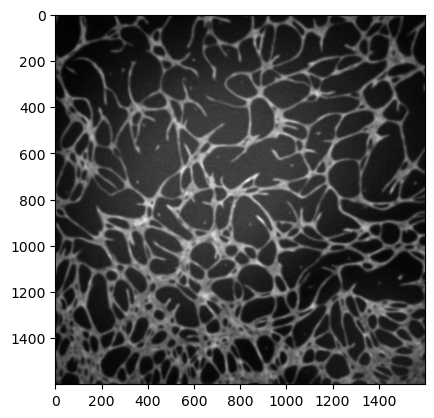

In [3]:
#Apply small gaussian blur
sigma = 3.5
blurred = gaussian(imgGrey, sigma=(sigma, sigma), truncate=3.5, channel_axis=-1)
plt.figure()
plt.imshow(blurred, cmap = 'gray')

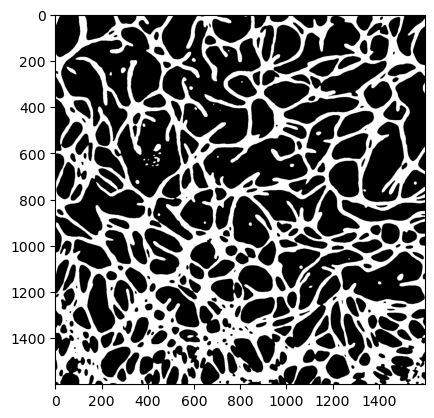

In [4]:
#Let's try some sauvola?
from skimage.filters import threshold_local
from skimage.morphology import disk
from skimage.filters.rank import otsu
import numpy as np

thresh = threshold_local(blurred , block_size = 301) 
bw = blurred > thresh

plt.imshow(bw, cmap = 'gray')

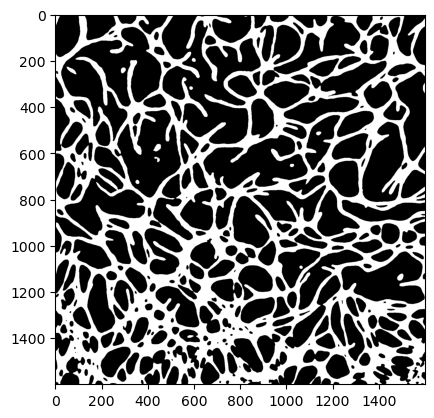

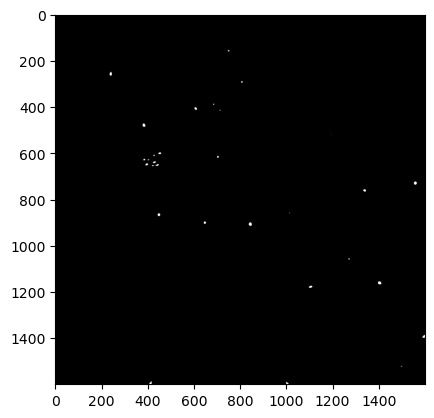

In [5]:
#Get rid of small areas
ensmallend = remove_small_objects(bw, min_size = 160, connectivity=8)
plt.imshow(ensmallend, cmap = 'gray')
diff = bw ^ ensmallend
plt.figure()
plt.imshow(diff, cmap='gray')

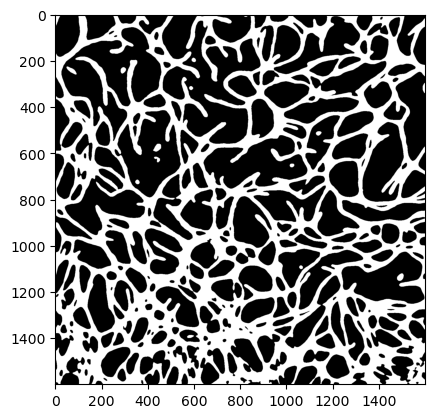

In [6]:
#Close Holes
from skimage.morphology import remove_small_holes, isotropic_dilation
#remove small holes
unholed = remove_small_holes(ensmallend, area_threshold = 100)
#morphological closing
dilated = isotropic_dilation(unholed, 1) #Dilation only used for skeleton

plt.imshow(dilated, cmap='gray')

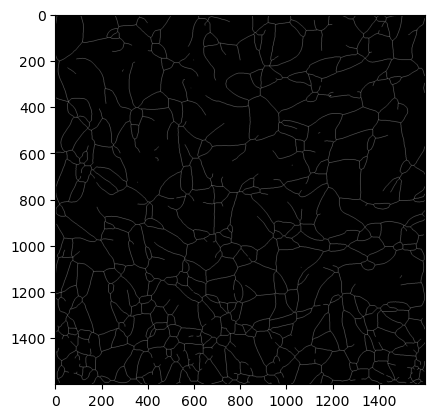

In [7]:
skel = skeletonize(dilated)
plt.imshow(skel, cmap='gray')

In [8]:
#import skimage
#skimage.io.imsave("C:\\Users\\harry\\Downloads\\skel.tiff", skel)

c:\Users\harry\.conda\envs\thesis\Lib\site-packages\sknw\sknw.py:16: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit # my mark
c:\Users\harry\.conda\envs\thesis\Lib\site-packages\sknw\sknw.py:28: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit # trans index to r, c...
c:\Users\harry\.conda\envs\thesis\Lib\site-packages\sknw\sknw.py:38: NumbaDeprecationWarn

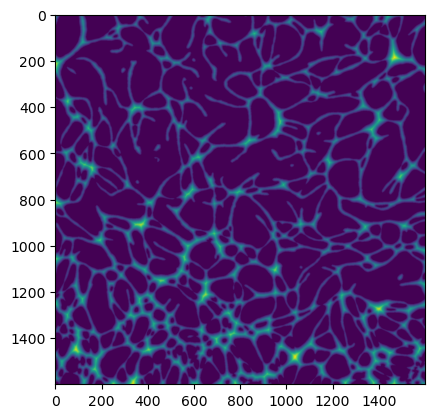

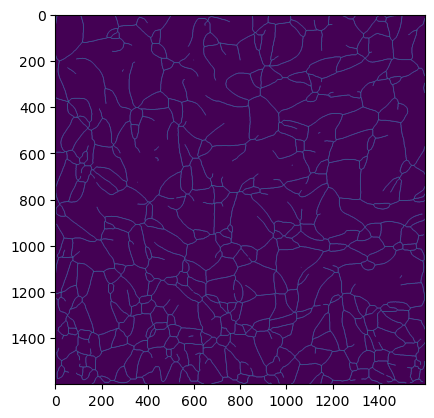

In [9]:
from dsepruning import skel_pruning_DSE
from scipy.ndimage import distance_transform_edt
skel_dist = distance_transform_edt(dilated,return_indices=False, return_distances=True)
plt.imshow(skel_dist)
pruned_skel = skel_pruning_DSE(skel,skel_dist,100)
plt.figure()
plt.imshow(pruned_skel)

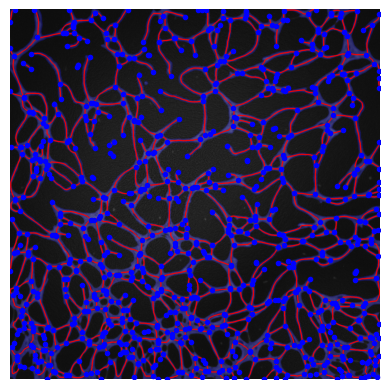

In [19]:
import sknw
from skan import draw
graph = sknw.build_sknw(pruned_skel)
nodes = graph.nodes()
ps = np.array([nodes[i]['o'] for i in nodes])

fig, ax = plt.subplots()
masked = label2rgb(dilated,image=img, colors = ['blue'], alpha=0.25)
draw.overlay_skeleton_2d(masked, pruned_skel, dilate=2, axes=ax)
plt.plot(ps[:,1], ps[:,0], 'b.')

In [38]:
import skan.csr
degree = skan.csr.make_degree_image(pruned_skel) 
branches = degree > 2
ends = np.nonzero(degree == 1)
positions = np.nonzero(branches)


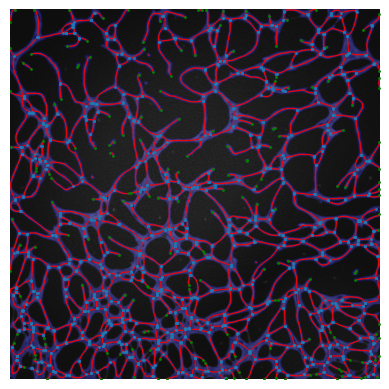

In [39]:
from skan import draw
fig, ax = plt.subplots()
masked = label2rgb(dilated,image=img, colors = ['blue'], alpha=0.25)
draw.overlay_skeleton_2d(masked, pruned_skel, dilate=2, axes=ax)
plt.scatter(positions[1], positions[0], s=1)
plt.scatter(ends[1], ends[0], s=1, color = ['green'])

In [66]:
#Set Cluster Distance
clusterDistance = 100
#np_pos = np.array(positions)
np_pos = np.vstack(positions).T
print(np_pos)
#Create a tree of points and query points until there are no points within the cluster distance
from scipy.spatial import KDTree
tree = KDTree(np_pos, compact_nodes=False, copy_data=True, balanced_tree=True)
points = list(tree.query_pairs(clusterDistance, p = 2)) #tuple -> immutable
#traversed = [False for i in range len(points)] #Boolean to denote if traversed
#Go through each of these cluster points, whittle down and remove them
# for point in points:
#     #Find all points close to given point
print(len(points))
    

[[   8 1186]
 [   8 1499]
 [   9 1185]
 ...
 [1592  830]
 [1596  932]
 [1596  933]]
26694


In [69]:
touched = [False for i in range(len(points))] #Stores if we've touched a given branch point
newPoints = []
for i in range(len(points)):
    point = points[i]
    closePoints = tree.query_ball_point(point, clusterDistance)
    if len(closePoints) > 0 and not touched[i]:
        #create list of tuples and adjust touched list
        closePointPositions = [points[j] for j in closePoints if not touched[j]]
        #Average Positions:
        x = sum(j[0] for j in closePointPositions)/len(closePoints)
        y = sum(j[1] for j in closePointPositions)/len(closePoints)
        #mark all points as touched
        for point in closePoints: touched[point] = True
        touched[i] = True
        #append averaged position to newPoints
        newPoints.append([x,y])
    elif not touched[i]:
        newPoints.append(point)
        touched[i] = True
print(np.shape(newPoints))

(26346, 2)


In [42]:
# Get number of cells
numPoints = len(positions[0])
# Size of image
imgSize = np.size(imgGrey)
# Area of Vessels
vesselArea = np.count_nonzero(dilated)
# Percentage Area
percentArea = vesselArea/imgSize * 100
print(imgSize, vesselArea, percentArea)
vesselLength = np.count_nonzero(pruned_skel)
print(vesselLength)
print(numPoints)
print(np.shape(ends))

2560000 993331 38.8019921875
49096
1888
(2, 190)
